이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import torch
import torchvision.transforms as transforms
from PIL import Image
import cv2

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import zipfile

# 압축 파일 경로
zip_path1 = '/content/drive/MyDrive/DAT/fashion-mnist_train.csv.zip'
zip_path2 = '/content/drive/MyDrive/DAT/fashion-mnist_test.csv.zip'
# 압축 해제 경로
extract_path = '/content/drive/MyDrive/DAT/'

# train
with zipfile.ZipFile(zip_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
# test
with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [32]:
train_df = pd.read_csv('/content/drive/MyDrive/DAT/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DAT/fashion-mnist_test.csv')

###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [33]:
# 요약
print('[train데이터 요약]')
print(train_df.info())
print('\n[test데이터 요약]')
print(test_df.info())

[train데이터 요약]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None

[test데이터 요약]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None


In [34]:
# 모양
print('[train데이터 모양]')
print(train_df.shape)
print('\n[test데이터 모양]')
print(test_df.shape)

[train데이터 모양]
(60000, 785)

[test데이터 모양]
(10000, 785)


In [35]:
# 크기 (전체 요소 개수)
print('[train데이터 크기]')
print(train_df.size)
print('\n[test데이터 크기]')
print(test_df.size)

[train데이터 크기]
47100000

[test데이터 크기]
7850000


In [36]:
# 결측치 여부
print('[train데이터 결측치 여부]')
print(train_df.isnull().sum())      #컬럼별 결측치 개수
print('\n[test데이터 결측치 여부]')
print(test_df.isnull().sum())

[train데이터 결측치 여부]
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

[test데이터 결측치 여부]
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


### Data중 첫 번째 이미지를 보여주세요.

In [37]:
train_df.head(1)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
pixel_count = train_df.shape[1] - 1  # 레이블 제외한 픽셀 개수

# 이미지 크기 추정
image_size = int(pixel_count ** 0.5)
print(f"이미지 크기: {image_size}x{image_size}")

# 픽셀 개수가 1024이면 32*32
#             784이면 28*28

이미지 크기: 28x28


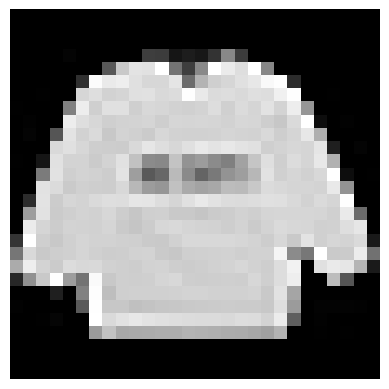

In [39]:
# 레이블을 제외한 픽셀 데이터만 추출
first_img = train_df.iloc[0,1:].values

# 픽셀 데이터를 배열(28*28)로 변환
img_array = first_img.reshape(28, 28)

plt.imshow(img_array, cmap='gray')
plt.axis('off')
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [40]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

# 레이블과 픽셀 데이터 분리

# 레이블은 정수형 텐서로 변환
train_labels = torch.tensor(train_df.iloc[:, 0].values, dtype=torch.long)
test_labels = torch.tensor(test_df.iloc[:, 0].values, dtype=torch.long)

# 이미지 데이터는 실수형 텐서로 변환
train_pixels = torch.tensor(train_df.iloc[:, 1:].values, dtype=torch.float32)
test_pixels = torch.tensor(test_df.iloc[:, 1:].values, dtype=torch.float32)

데이터를 텐서로 변환하면
- PyTorch 모델에 데이터를 직접 입력 가능
- DataLoader에 사용 가능 (배치 형태, 셔플, 증강 등)
- 속도 향상 등

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [41]:
# 이미지 데이터 정규화 (0 - 255 사이 값을 0 - 1로 변환)
train_pixels = train_pixels / 255.0

# 이미지 데이터를 28x28 크기의 2D 텐서로 변환
train_pixels = train_pixels.view(-1, 1, 28, 28)  # (배치 크기, 채널, 높이, 너비) 형태로 변환

print(f"정규화된 이미지 텐서 크기: {train_pixels.shape}")  # torch.Size([배치크기, 채널, 높이, 너비])
print(f"정규화된 첫 번째 이미지 데이터:\n{train_pixels[0]}")

정규화된 이미지 텐서 크기: torch.Size([60000, 1, 28, 28])
정규화된 첫 번째 이미지 데이터:
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.2431, 0.2392, 0.0824, 0.1137, 0.0902,

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

In [42]:
# 디노이징으로 노이즈 제거
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageFilter

# Gaussian Blur 필터를 적용할 수 있는 함수 정의
def denoise_image_tensor(image_tensor):
    # PyTorch 텐서를 PIL 이미지로 변환 (채널, 높이, 너비 순서를 높이, 너비, 채널로 변환)
    pil_image = transforms.ToPILImage()(image_tensor.squeeze(0))  # (1, 28, 28) -> (28, 28)

    # Gaussian Blur 필터 적용
    denoised_image = pil_image.filter(ImageFilter.GaussianBlur(radius=1))

    # PIL 이미지를 다시 텐서로 변환
    denoised_tensor = transforms.ToTensor()(denoised_image).unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    return denoised_tensor

# 모든 이미지에 필터 적용
denoised_train_pixels = torch.stack([denoise_image_tensor(img) for img in train_pixels])

print(f"데노이징된 이미지 텐서 크기: {denoised_train_pixels.shape}")
print(f"데노이징된 첫 번째 이미지 데이터:\n{denoised_train_pixels[0]}")


데노이징된 이미지 텐서 크기: torch.Size([60000, 1, 1, 28, 28])
데노이징된 첫 번째 이미지 데이터:
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0039, 0.0078, 0.0118, 0.0118, 0.0118, 0.0078, 0.0118, 0.0157,
           0.0196, 0.0196, 0.0078, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0118, 0.0275,
           0.0471, 0.0667, 0.0902, 0.0902, 0.0667, 0.0549, 0.0706, 0.1059,
           0.1294, 0.1098, 0.0706, 0.0353, 0.0118, 0.0039, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0039, 0.0078, 0.0275, 0.0706, 0.1412,
           0.2196, 0.2784, 0.3216, 0.3098, 0.23

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

PCA (Principal Component Analysis)
- 선형 차원 축소 기법으로, 속도가 빠르고 모델에 데이터를 입력하기 전 데이터의 주요 패턴을 선형적으로 요약할 때 사용


t-sne (t-distributed Stochastic Neighbor Embedding)
- 비선형 차원 축소 기법으로, 데이터의 군집(클러스터) 시각화에 적합하다. 느리지만 고차원 데이터의 복잡한 패턴을 저차원에서 명확히 볼 수 있음.

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [48]:
from sklearn.decomposition import PCA

# 이미지 데이터를 (샘플 수, 784) 형태의 배열로 변환
train_pixels_flat = train_pixels.view(train_pixels.size(0), -1).numpy()  # (샘플 수, 784)
test_pixels_flat = test_pixels.view(test_pixels.size(0), -1).numpy()    # (샘플 수, 784)

# PCA 모델 생성 및 50차원으로 변환
pca = PCA(n_components=50)
train_pixels_pca = pca.fit_transform(train_pixels_flat)
test_pixels_pca = pca.transform(test_pixels_flat)

# PCA 결과를 다시 텐서로 변환
train_pixels_pca_tensor = torch.tensor(train_pixels_pca, dtype=torch.float32)
test_pixels_pca_tensor = torch.tensor(test_pixels_pca, dtype=torch.float32)

print(f"원본 train 데이터 차원: {train_pixels.shape}")  # (샘플 수, 1, 28, 28)
print(f"PCA 변환 후 train 데이터 차원: {train_pixels_pca_tensor.shape}")  # (샘플 수, 50)
print(f"원본 test 데이터 차원: {test_pixels.shape}")  # (샘플 수, 1, 28, 28)
print(f"PCA 변환 후 test 데이터 차원: {test_pixels_pca_tensor.shape}")  # (샘플 수, 50)

원본 train 데이터 차원: torch.Size([60000, 1, 28, 28])
PCA 변환 후 train 데이터 차원: torch.Size([60000, 50])
원본 test 데이터 차원: torch.Size([10000, 784])
PCA 변환 후 test 데이터 차원: torch.Size([10000, 50])


### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [ ]:
from sklearn.decomposition import PCA



### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.


(더블클릭해서 이곳에 작성)